<a href="https://colab.research.google.com/github/diego200052/Aprendizaje-Profundo-Tarea02-MMDR/blob/master/Tarea02-Ejercicio01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Operación de convolución

Extiende la operación de convolución para imágenes en escala de grises (un solo canal) vista en clase (https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2a_convolucion.ipynb) a imágenes a color (múltiples canales).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

## Carga de imagen RGB
Vamos a cargar un par de imagenes RGB para realizar la convolución.

In [2]:
!wget -nc https://raw.githubusercontent.com/diego200052/Aprendizaje-Profundo-Tarea02-MMDR/main/data/flowers/0001.jpg
!wget -nc https://raw.githubusercontent.com/diego200052/Aprendizaje-Profundo-Tarea02-MMDR/main/data/flowers/0007.jpg

--2022-11-14 03:48:11--  https://raw.githubusercontent.com/diego200052/Aprendizaje-Profundo-Tarea02-MMDR/main/data/flowers/0001.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17349 (17K) [image/jpeg]
Saving to: ‘0001.jpg’

0001.jpg            100%[===================>]  16.94K  --.-KB/s    in 0.001s  

2022-11-14 03:48:11 (25.9 MB/s) - ‘0001.jpg’ saved [17349/17349]

--2022-11-14 03:48:12--  https://raw.githubusercontent.com/diego200052/Aprendizaje-Profundo-Tarea02-MMDR/main/data/flowers/0007.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response

In [3]:
import numpy as np
from PIL import Image

imagen1raw = np.array(Image.open('0001.jpg'))
imagen2raw = np.array(Image.open('0007.jpg'))

Es conveniente normalizar los valores de las imágenes para que estén en el mismo rango ($0-1$). 

In [4]:
imagen1raw = imagen1raw / imagen1raw.max()
imagen2raw = imagen2raw / imagen2raw.max()

Estas imagenes son de dimensiones $128 \times 128$ de flores con 3 canales (RGB).

In [5]:
print(f"Shape de imagen 1: {imagen1raw.shape} \n\nDatos de imagen 1:{imagen1raw}")

Shape de imagen 1: (128, 128, 3) 

Datos de imagen 1:[[[0.05490196 0.08627451 0.04313725]
  [0.05490196 0.08627451 0.04313725]
  [0.0627451  0.09411765 0.04313725]
  ...
  [0.50588235 0.59215686 0.25882353]
  [0.49019608 0.58431373 0.28627451]
  [0.4745098  0.56470588 0.35294118]]

 [[0.05098039 0.09019608 0.04705882]
  [0.05882353 0.09803922 0.05490196]
  [0.05882353 0.10196078 0.04705882]
  ...
  [0.50196078 0.56470588 0.31764706]
  [0.58823529 0.67058824 0.41568627]
  [0.5254902  0.60784314 0.38431373]]

 [[0.04313725 0.08627451 0.03137255]
  [0.0627451  0.10588235 0.05098039]
  [0.0627451  0.10588235 0.05098039]
  ...
  [0.22352941 0.26666667 0.14117647]
  [0.45490196 0.5254902  0.3372549 ]
  [0.53333333 0.61960784 0.37647059]]

 ...

 [[0.35686275 0.29803922 0.22352941]
  [0.37254902 0.30588235 0.22745098]
  [0.37647059 0.30980392 0.23137255]
  ...
  [0.29411765 0.24705882 0.19215686]
  [0.25882353 0.19215686 0.16470588]
  [0.23137255 0.15294118 0.16078431]]

 [[0.35294118 0.29411

Visualicemos las 2 imagenes:

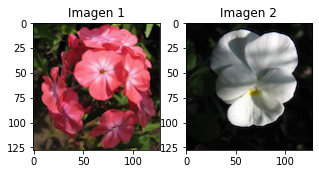

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[0].imshow(imagen1raw)
axs[0].set_title('Imagen 1')
axs[1].imshow(imagen2raw)
axs[1].set_title('Imagen 2')
plt.show()

Las imagenes se encuentran en formato $H \times W \times C$, tal que $H$ es la altura, $W$ es el ancho y $C$ el número de canales. Sin embargo, para hacer la convolución se requiere que estén en el siguiente formato: $C \times H \times W$.

In [7]:
print("Imagen 1", imagen1raw.shape)
imagen1 = np.moveaxis(imagen1raw, -1, 0)
print(imagen1.shape)
print("-------------")
print("Imagen 2", imagen2raw.shape)
imagen2 = np.moveaxis(imagen2raw, -1, 0)
print(imagen2.shape)

Imagen 1 (128, 128, 3)
(3, 128, 128)
-------------
Imagen 2 (128, 128, 3)
(3, 128, 128)


## Convolución y correlación cruzada
Ahora consideremos las operación de convolución entre una imagen $I$ y un filtro $W$, la cual está definida por

$$
A_{i,j} = (\mathbf{I} * \mathbf{W})_{i,j} = \sum_m \sum_n I_{m, n} W_{i - m, j - n}
$$

La convolución es commutativa, por lo tanto 

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i - m, j - n} W_{m,n}
$$

En lugar de la convolución, frecuentemente se ocupa la operación de correlación cruzada para llevar a cabo las capas convolucionales. Esta operación es similar a la convolución pero sin voltear el filtro (por lo que pierde la propiedad de conmutatividad) y está dada por

$$
A_{i,j} = (\mathbf{W} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i + m, j + n} W_{m,n} 
$$

El resultado de estas operaciones es el mapa de activaciones $A(i,j)$. 



In [8]:
def conv2d(I, W, b, stride = 1):
    
    print("I:", I.shape)
    print("W:", W.shape)
    
    if(len(I.shape) != len(W.shape)):
        print("[Error]: La dimensión de I no corresponde con el filtro W.")
        return
    
    # Se calcula el tamaño del vector de salida de la convolución
    h_s = int(np.floor((I.shape[1] - W.shape[1]) / stride)) + 1
    w_s = int(np.floor((I.shape[2] - W.shape[2]) / stride)) + 1
    a = None
    
    print("h_s:", h_s)
    print("w_s:", w_s)
    
    if(len(I.shape) == 2): # Formato: (H x W)
        
        # Se crea el vector de salida e inicializa con ceros
        a = np.zeros((h_s, w_s))
        
        # Se realiza la convolución
        for i in range(h_s):
            for j in range(w_s):
                I_m = I[i * stride:i * stride + W.shape[0], j * stride:j * stride + W.shape[1]]
                a[i, j] = (I_m * W).sum() + b

    elif(len(I.shape) == 3): # Formato: (C x H x W)
        
        # Se obtiene el número de canales
        channels = I.shape[0]
        # Se crea el vector de salida e inicializa con ceros
        a = np.zeros((h_s, w_s))
        
        # Se realiza la convolución
        for c in range(channels):
            for i in range(h_s):
                for j in range(w_s):
                    I_m = I[c, i * stride:i * stride + W.shape[1], j * stride:j * stride + W.shape[2]]
                    W_m = W[c] #Filtro en canal c
                    a[i, j] += (I_m * W_m).sum() + b #Se multiplica I_m
        
    return a

Para una convolución con múltiples canales a la entrada, se necesita construir un kernel con el mismo número de canales que la entrada. Por lo tanto, si la imagen tiene la forma $C \times H \times W$, entonces el filtro debe tener la forma $C \times k_H \times k_W$, tal que $C$ es el número de canales y es mayor a 1, $H$ es la altura de la entrada, $W$ es el ancho de la entrada, $k_H$ es la altura del filtro y $k_H$ es el ancho del filtro.
  
A continuación se muestra una representación gráfica. Imagen modificada de: https://d2l.ai/chapter_convolutional-neural-networks/channels.html
<br>
<center><img src="https://github.com/diego200052/Aprendizaje-Profundo-Tarea02-MMDR/blob/main/img/correlacion-cruzada_4_80.png?raw=true" alt="drawing" style="width:600px;"/></center>

## Filtro
 
A continuación se define un filtro de $3 \times 3 \times 3$ que detecte bordes en cierta orientación y se vizualiza uno de los canales, por simplicidad, el filtro tendrá los mismos valores para todos los canales:

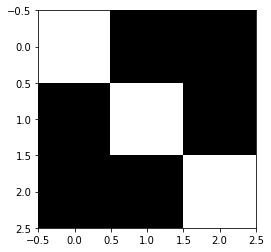

[[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]


In [9]:
filter3D = np.zeros((3,3,3))
np.fill_diagonal(filter3D[0], np.array([1, 1, 1]))
np.fill_diagonal(filter3D[1], np.array([1, 1, 1]))
np.fill_diagonal(filter3D[2], np.array([1, 1, 1]))
plt.imshow(filter3D[0], cmap = 'gray') 
plt.show()
print(filter3D)

## Operación

Aplicando las operaciones de correlación cruzada de una imagen con dicho filtro y se obtiene lo siguiente:

I: (3, 128, 128)
W: (3, 3, 3)
h_s: 126
w_s: 126


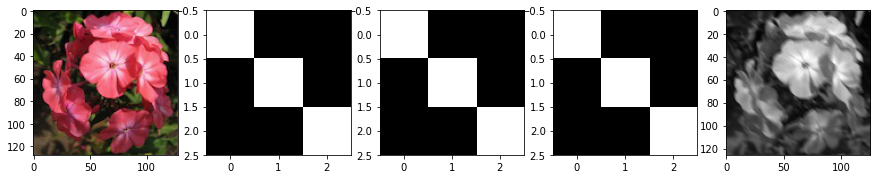

In [10]:
# Se realiza la operación de correlación cruzada
mapaA1 = conv2d(imagen1, filter3D, 0) #(C X H X W) * (C X k_H X k_W)

# Se grafican los resultados
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
axs[0].imshow(imagen1raw) # Imagen RGB (H X W X C)
axs[1].imshow(filter3D[0], cmap = 'gray') # Filtro canal 1
axs[2].imshow(filter3D[1], cmap = 'gray') # Filtro canal 2
axs[3].imshow(filter3D[2], cmap = 'gray') # Filtro canal 3
axs[4].imshow(mapaA1, cmap = 'gray') # Correlación cruzada
plt.show()

I: (3, 128, 128)
W: (3, 3, 3)
h_s: 126
w_s: 126


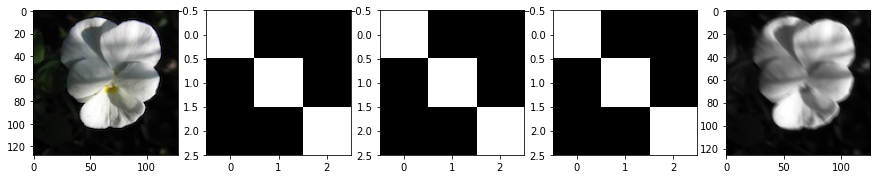

In [11]:
mapaA2 = conv2d(imagen2, filter3D, 0)
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
axs[0].imshow(imagen2raw) # Imagen RGB (H X W X C)
axs[1].imshow(filter3D[0], cmap = 'gray') # Filtro canal 1
axs[2].imshow(filter3D[1], cmap = 'gray') # Filtro canal 2
axs[3].imshow(filter3D[2], cmap = 'gray') # Filtro canal 3
axs[4].imshow(mapaA2, cmap = 'gray') # Correlación cruzada
plt.show()

Otro ejemplo. Podemos definir un filtro de $3 \times 5\times 5$:

(3, 5, 5)


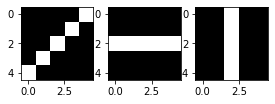

In [12]:
filter1 = np.zeros((5,5))
np.fill_diagonal(filter1, np.array([1, 1, 1, 1, 1]))

filter3D_2 = np.zeros((3, 5, 5))
filter3D_2[0, :, :] = filter1[::-1]
filter3D_2[1, 2, :] = 1
filter3D_2[2, :, 2] = 1

print(filter3D_2.shape)

plt.subplot(1,4,1)
plt.imshow(filter3D_2[0], cmap = 'gray') 
plt.subplot(1,4,2)
plt.imshow(filter3D_2[1], cmap = 'gray') 
plt.subplot(1,4,3)
plt.imshow(filter3D_2[2], cmap = 'gray') 
plt.show()

I: (3, 128, 128)
W: (3, 5, 5)
h_s: 124
w_s: 124


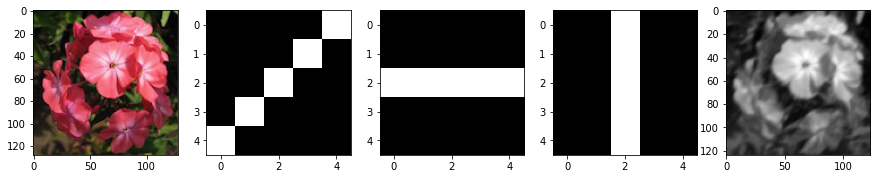

In [13]:
# Se realiza la operación de correlación cruzada
mapaA1_2 = conv2d(imagen1, filter3D_2, 0) #(C X H X W) * (C X k_H X k_W)

# Se grafican los resultados
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
axs[0].imshow(imagen1raw) # Imagen RGB (H X W X C)
axs[1].imshow(filter3D_2[0], cmap = 'gray') # Filtro canal 1
axs[2].imshow(filter3D_2[1], cmap = 'gray') # Filtro canal 2
axs[3].imshow(filter3D_2[2], cmap = 'gray') # Filtro canal 3
axs[4].imshow(mapaA1_2, cmap = 'gray') # Correlación cruzada
plt.show()

I: (3, 128, 128)
W: (3, 5, 5)
h_s: 124
w_s: 124


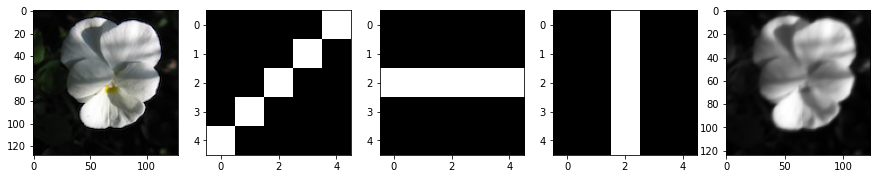

In [14]:
# Se realiza la operación de correlación cruzada
mapaA2_2 = conv2d(imagen2, filter3D_2, 0) #(C X H X W) * (C X k_H X k_W)

# Se grafican los resultados
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
axs[0].imshow(imagen2raw) # Imagen RGB (H X W X C)
axs[1].imshow(filter3D_2[0], cmap = 'gray') # Filtro canal 1
axs[2].imshow(filter3D_2[1], cmap = 'gray') # Filtro canal 2
axs[3].imshow(filter3D_2[2], cmap = 'gray') # Filtro canal 3
axs[4].imshow(mapaA2_2, cmap = 'gray') # Correlación cruzada
plt.show()

# Conclusión

Extender la operación de convolución 2D a múltiples canales de entrada, se obtiene agregando una nueva iteración, con el objetivo de realizar la misma operación, pero por cada canal independiente. Así la matriz de activaciones resultante a la salida, va a ser la suma de todas las convoluciones de la entrada y el filtro, por canal como se mostró en el diagrama más arriba. Si se quiera realizar la convolución 2D, pero con más de 1 mapa de activaciones a la salida, se requerirían un filtro de la siguiente forma: $O \times C \times H \times W$ tal que $O$ es el número de canales a la salida. Bastaría con agregar otra iteración sobre los canales a la salida para generar un total de $O$ mapas de activación.